<center><h1>Tesla Stock ARIMAS Case Study</h1> </center>

<center><h2>Cho Kim, Jason Lin, Jonathan Marin</h2> </center>

<br/>

<center><h2>March 7, 2019</h2></center>

## 1 Introduction

This case study is studying the application of the ARIMA time series method to the Tesla (TSLA) closing stock price series going from January 1, 2015 to February 1, 2019. The study is attempting to apply the use of the Augmented Dickey-Fuller test for stationarity, and the use of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) in determining the differencing and the number of Autoregressive and Moving Average terms that should be applied. Then applying the brute force methodology, and then using fit statistics to determine which is the best fit, while trying to keep the model as simple as possible.  

## 2 Methods

Utilizing the `statsmodels.tsa` library for the time series package, the following will show the different exploratory data analysis done on the Tesla Closing Price Stock time series. Also, we analyzed the differenced series to see if this transformation should be used.

In [6]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 5]

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

The code above is used to import the different libraries used in time series analysis. A function is also created to calculate the Augmented Dickey-Fuller Test, and also to plot the original time series.

### Original Tesla Stock Series

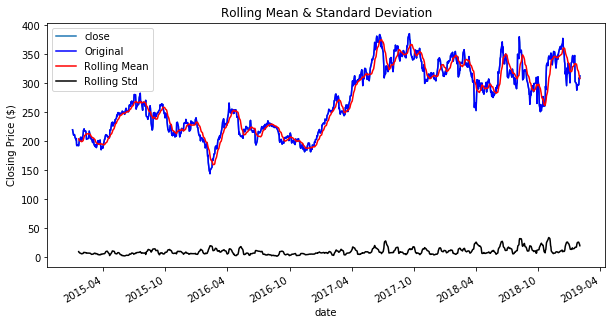

Results of Dickey-Fuller Test:
Test Statistic                   -2.218876
p-value                           0.199466
#Lags Used                        0.000000
Number of Observations Used    1027.000000
Critical Value (1%)              -3.436733
Critical Value (5%)              -2.864358
Critical Value (10%)             -2.568271
dtype: float64


In [7]:
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 2, 1)
price = web.DataReader('TSLA', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)
plt.ylabel('Closing Price ($)')
price.plot()

test_stationarity(price)

When looking at the time series plot of Tesla Stocks, we can see that there might be a trend i.e. a non-constant mean. The series also shows there is volatility, a lot of jumping back and forth, especially during the 2017 to 2019 period. The non-constant mean and volatility indicates that there could be non-stationarity in the time series. This is further supported by the Augmented Dickey-Fuller test since the p-value is greater than 0.1 indicating that it failed to reject the null hypothesis where the null indicates a unit root, i.e. non-stationarity. Therefore, differencing should be used to see if the time series can be made stationary.

### First Differencing of Tesla Stock Series

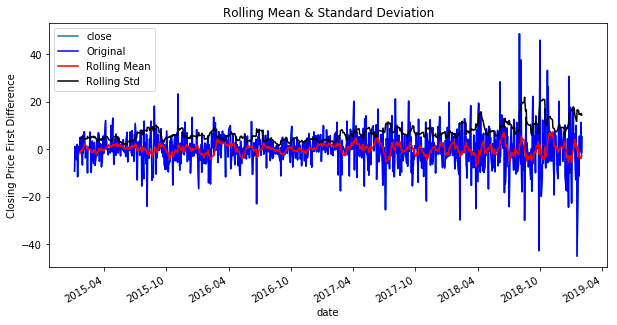

Results of Dickey-Fuller Test:
Test Statistic                  -32.933469
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1026.000000
Critical Value (1%)              -3.436740
Critical Value (5%)              -2.864361
Critical Value (10%)             -2.568272
dtype: float64


In [8]:
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
plt.ylabel('Closing Price First Difference')
test_stationarity(diff)

When looking at the time series plot of the first differenced price, we can see clearly that there is a constant mean and volatility looks to be constant. When reviewing the Augmented Dickey-Fuller Test we can clearly see that the p-value is less than 0.01 indicating a rejection of the null hypothesis. This seems to show that there is enough statistical evidence that there is no unit root in the time series. Therefore, when using ARIMA models, the first differenced should be used in estimating the model and forecasting and not the original time series.

### ACF and PACF of First Differenced Tesla Stock Price

Text(0,0.5,'Correlation')

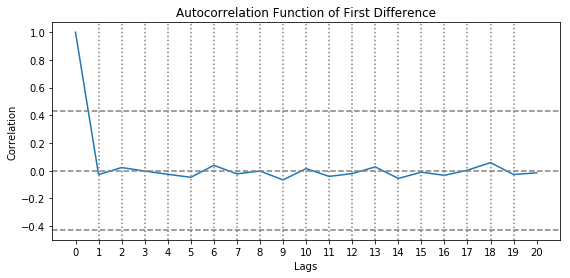

In [9]:
acf_air_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function of First Difference')
plt.xlabel('Lags')
plt.ylabel('Correlation')

Text(0,0.5,'Correlation')

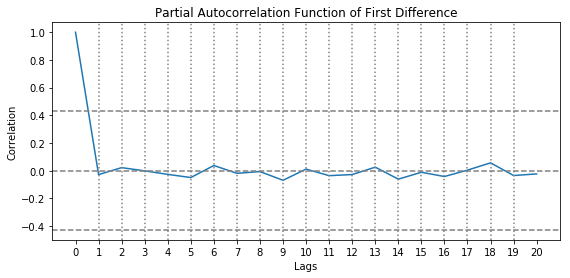

In [10]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function of First Difference')
plt.xlabel('Lags')
plt.ylabel('Correlation')

When plotting the ACF curve, we can see that it has a quick and steady decline to zero, where the series goes to zero by lag 1 indicating stationarity. Since there are no values that fall of the confidence interval for either ACF and PACF, and actually many of the correlations stay around the zero range, we can see there is no indication of seasonality. When plotting the PACF, we can see that there are no lags that are significant.

## 3 Results

### Brute Force ARIMA

249.3316424662291


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


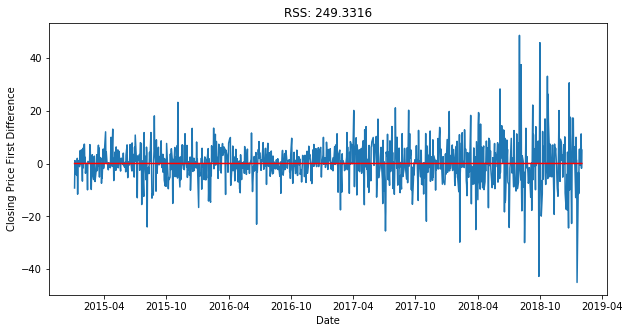

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 0 0
249.23639944971075


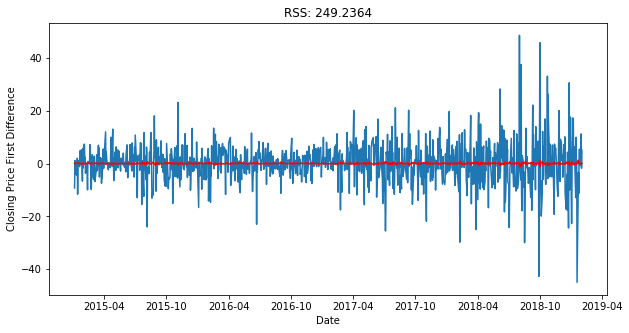

0 0 1
249.1677227499487


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


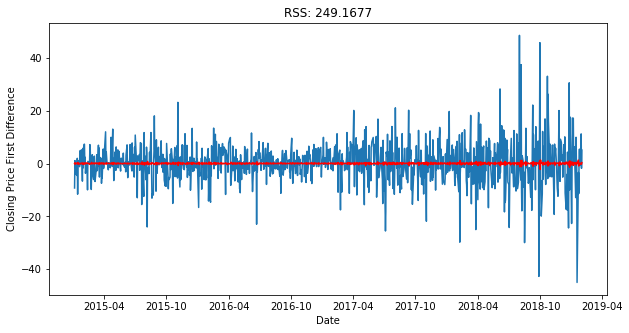

0 0 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


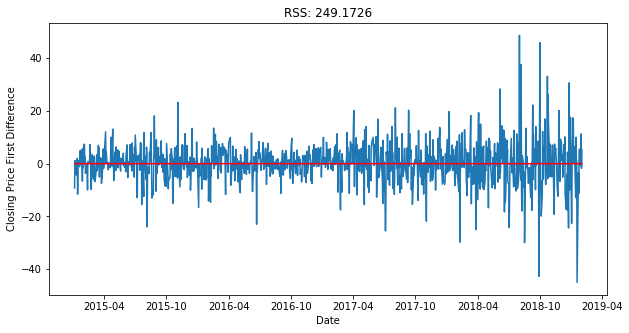

0 1 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


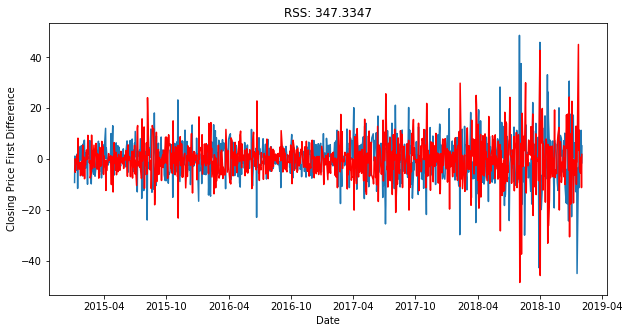

0 1 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


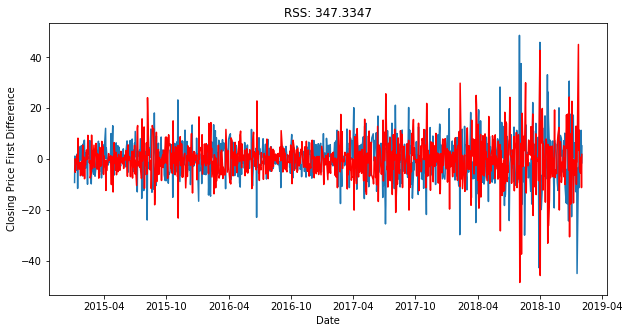

0 1 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


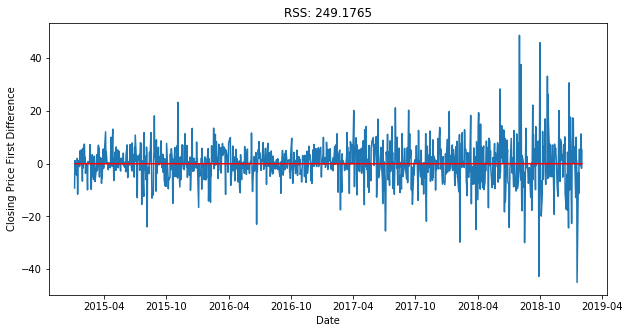

0 2 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


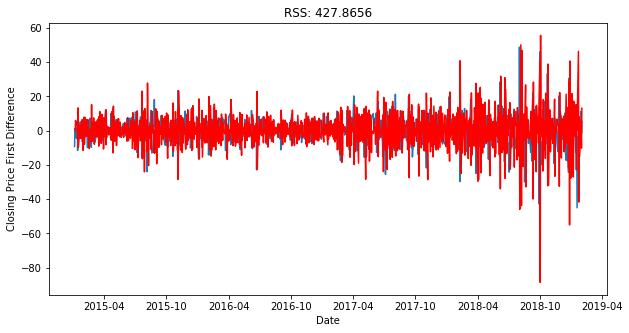

0 2 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


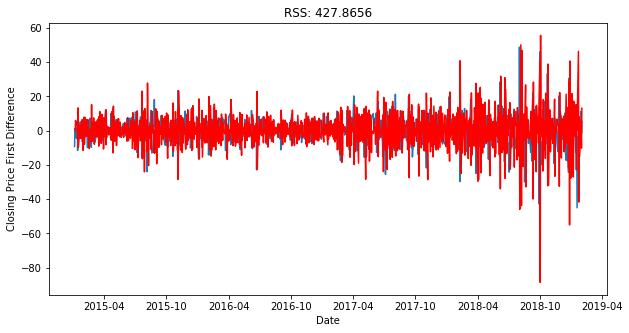

0 2 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


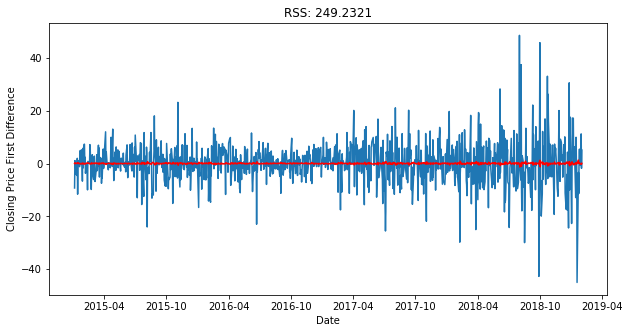

1 0 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


249.03362729650482


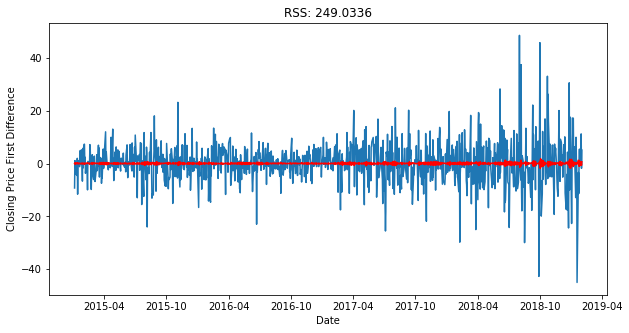

1 0 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


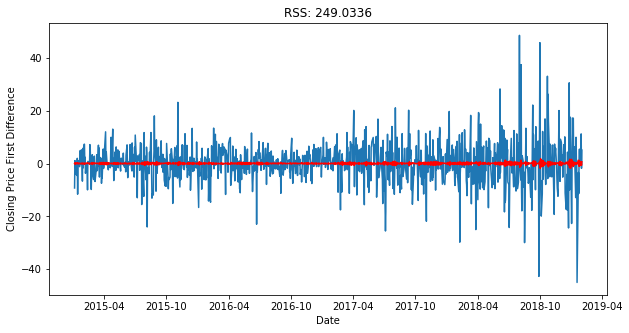

1 0 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


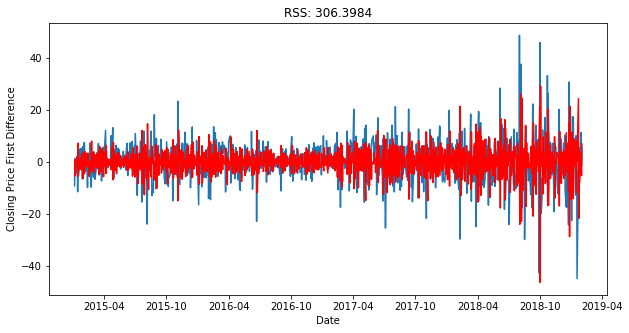

1 1 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


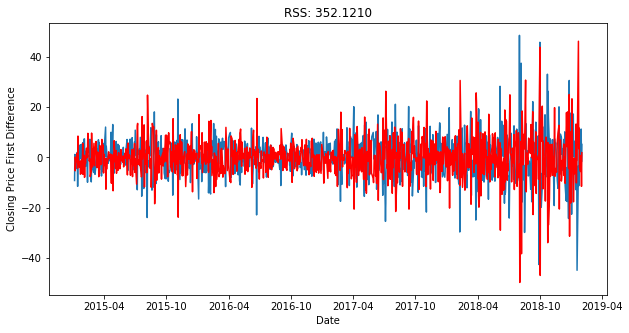

1 1 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


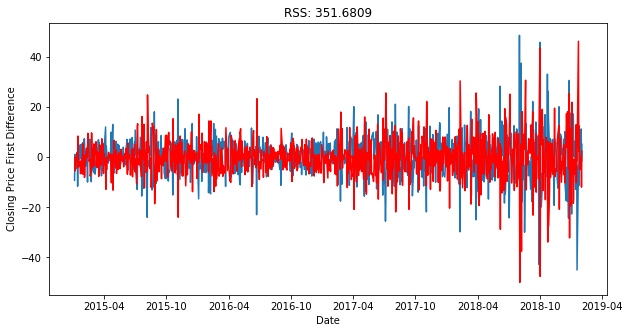

1 1 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


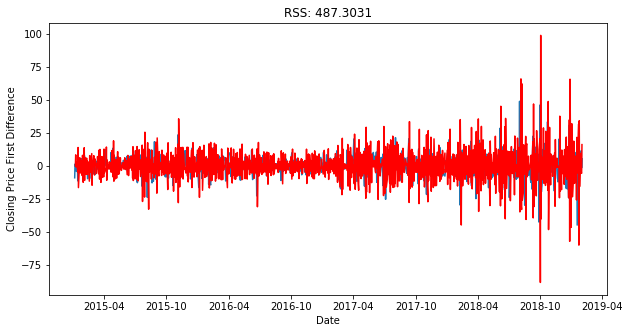

1 2 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


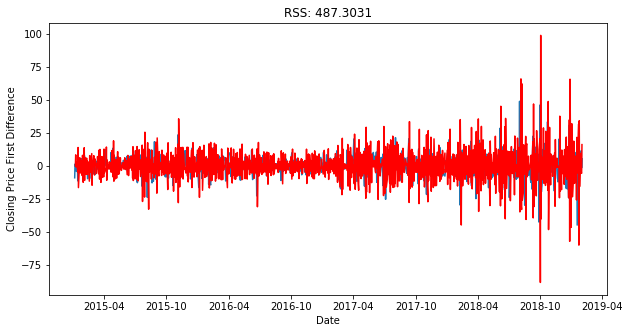

1 2 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


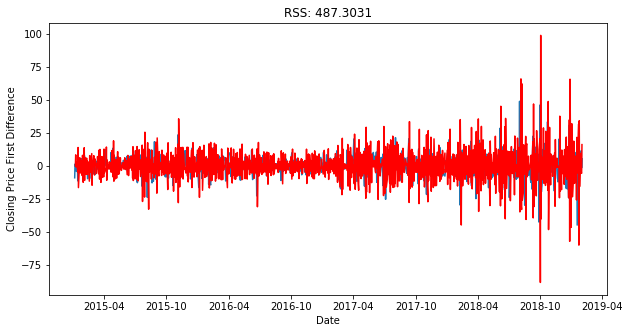

1 2 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


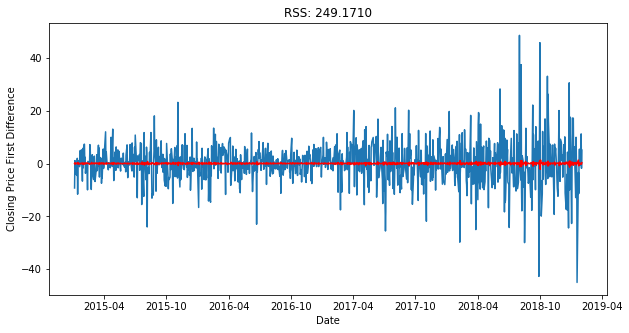

2 0 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


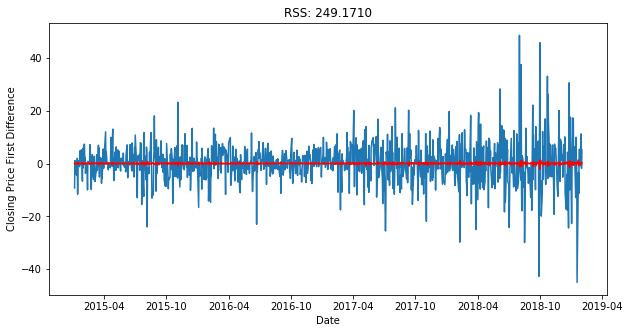

2 0 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


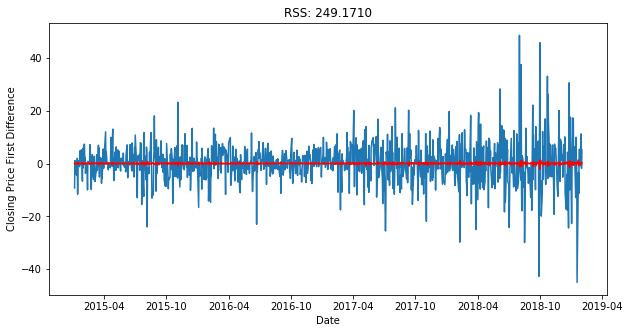

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 0 2


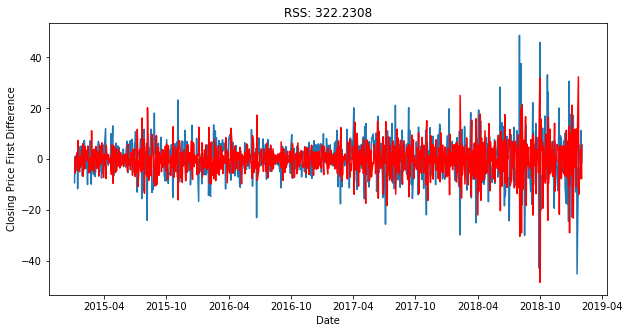

2 1 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


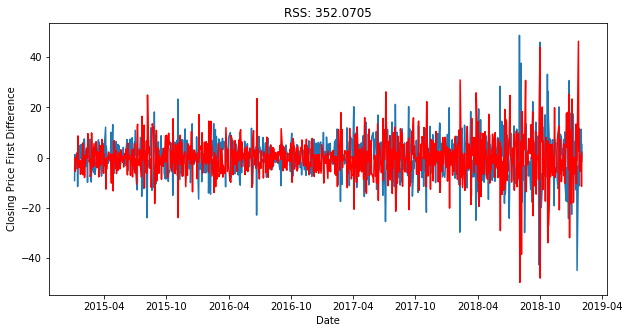

2 1 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


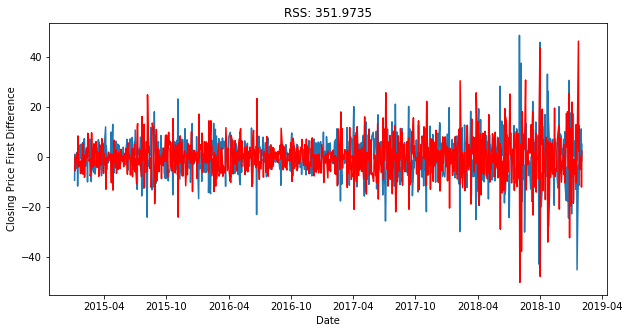

2 1 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


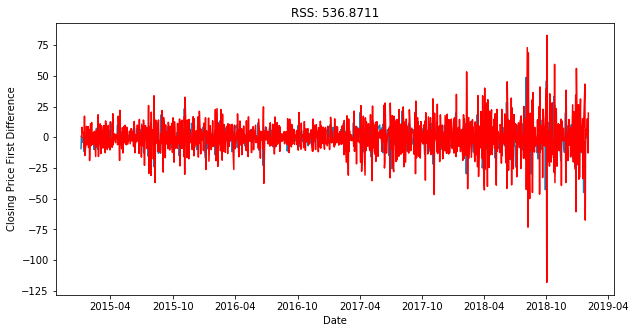

2 2 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


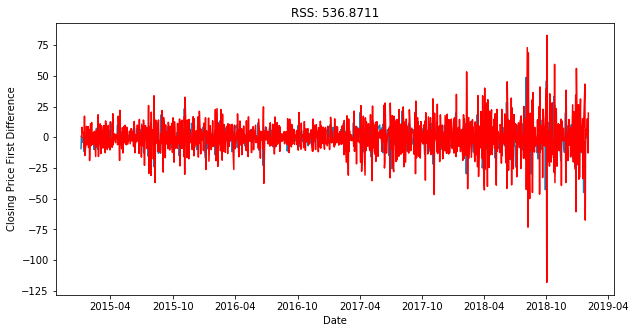

2 2 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


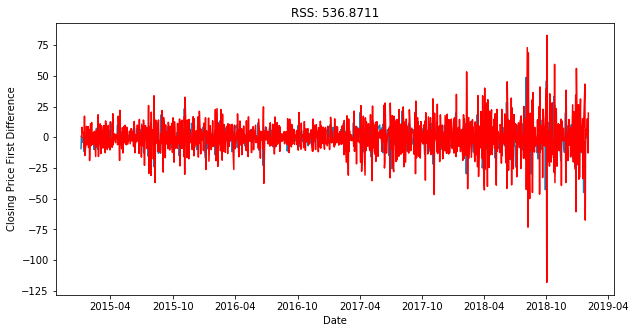

2 2 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


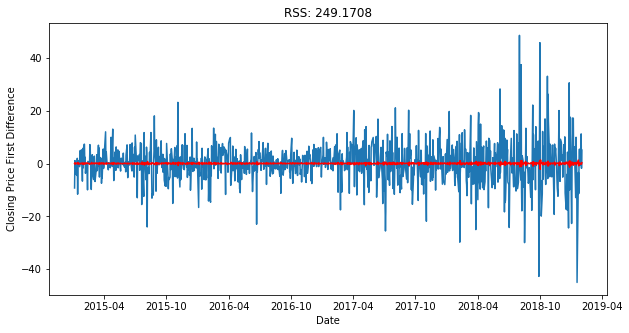

3 0 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


248.32432811281126


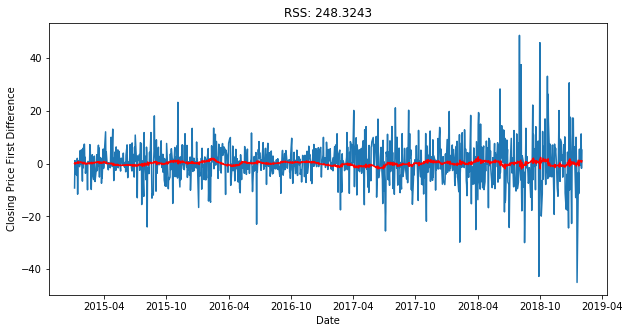

3 0 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


246.34808711067012


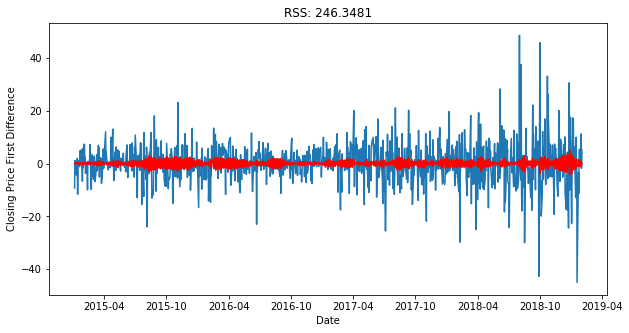

3 0 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


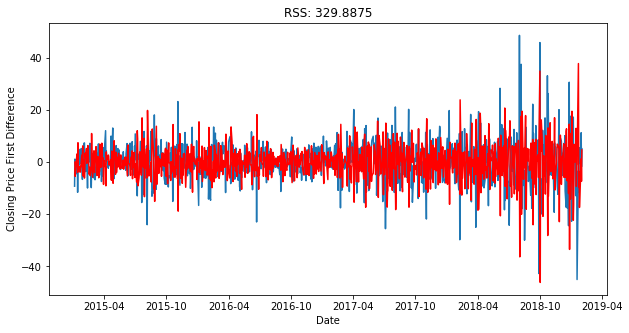

3 1 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


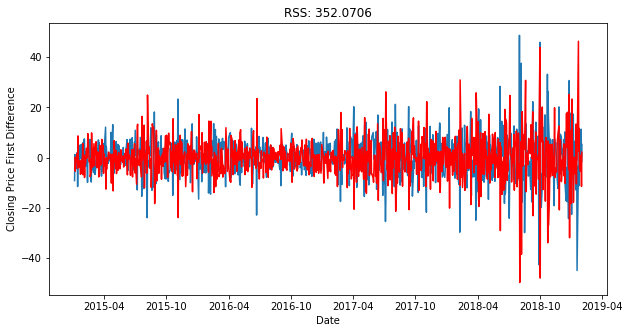

3 1 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


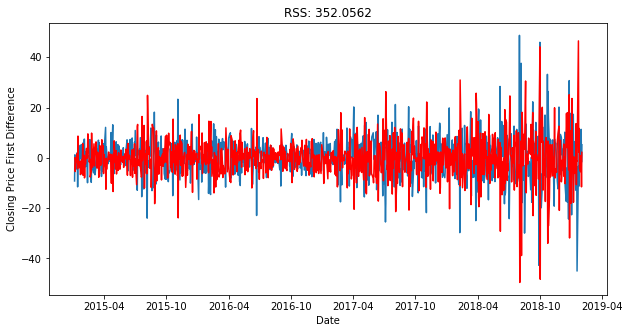

3 1 2


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


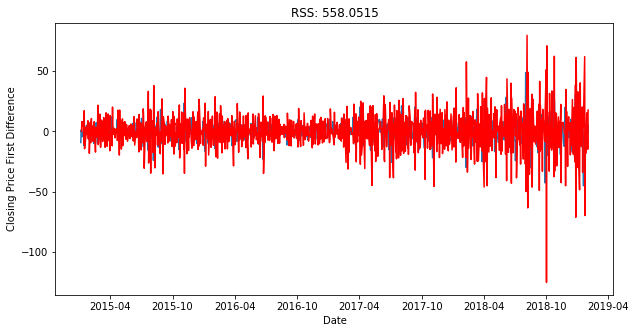

3 2 0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


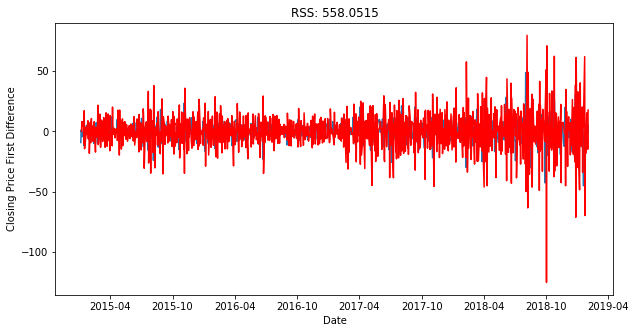

3 2 1


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


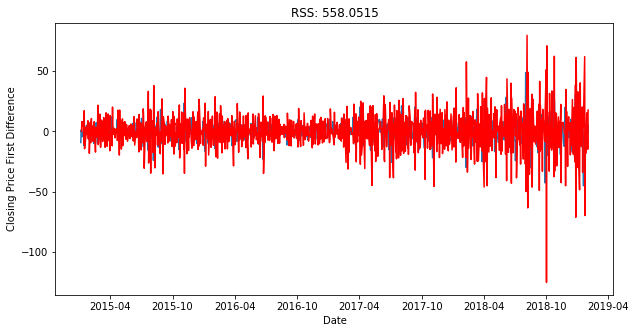

3 2 2


In [11]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.xlabel('Date')
            plt.ylabel('Closing Price First Difference')
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

### Analysis of the Second Differencing Tesla Stock Price Series

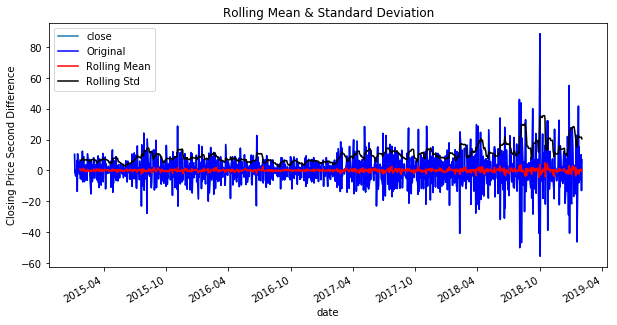

Results of Dickey-Fuller Test:
Test Statistic                -1.205311e+01
p-value                        2.570057e-22
#Lags Used                     2.100000e+01
Number of Observations Used    1.004000e+03
Critical Value (1%)           -3.436880e+00
Critical Value (5%)           -2.864423e+00
Critical Value (10%)          -2.568305e+00
dtype: float64


In [12]:
diff2=diff-diff.shift()
diff2.dropna(inplace=True)
diff2.plot()
plt.ylabel('Closing Price Second Difference')
test_stationarity(diff2)

Text(0,0.5,'Correlation')

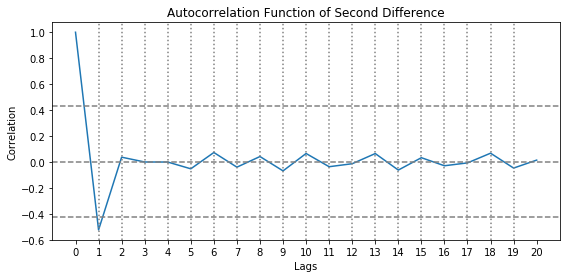

In [13]:
acf_air_plot = acf(diff2, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function of Second Difference')
plt.xlabel('Lags')
plt.ylabel('Correlation')

Text(0,0.5,'Correlation')

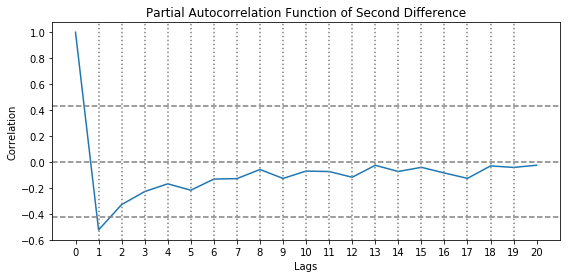

In [14]:
pacf_air_plot = pacf(diff2, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function of Second Difference')
plt.xlabel('Lags')
plt.ylabel('Correlation')

The above brute force code is using the first differenced data Tesla stock price for the brute force ARIMA modeling. When looking through the output based on plot only, it seems to show that `d = 1` or `d = 2` may have better fit since the red plot follows the blue plot closely indicating that higher order differencing maybe needed. However, as shown in the analysis above for the second difference, the ACF and PACF alone all show that lag 1 is close to -0.5 indicating overdifferencing. The Augmented Dickey-Fuller also indicates non-stationarity when second differenced. Therefore, the only results that are analyzed are where `d = 0`. Although the plots do not show good fit for `d = 0`, however, the Residual Sum of Squares (RSS) are much lower compared to the higher order differencing. 

When looking through these results, it seems to show that an ARIMA model (3,0,2) is the best fit, where the model has the lowest RSS of `246.3481`. However, another result ARIMA (3,0,1) also shows good fit with an RSS of `248.3243`. Because of the pretty significant drop of the RSS and the plot of ARIMA (3,0,2) shows closer fit to the original, ARIMA(3,0,2) is the final model chosen.

## 4 Conclusion

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1027
Model:                     ARMA(3, 2)   Log Likelihood               -3552.690
Method:                       css-mle   S.D. of innovations              7.673
Date:                Thu, 07 Mar 2019   AIC                           7119.380
Time:                        20:34:31   BIC                           7153.921
Sample:                             0   HQIC                          7132.491
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0904      0.240      0.377      0.706      -0.380       0.560
ar.L1.close    -0.0347      0.031     -1.103      0.270      -0.096       0.027
ar.L2.close    -0.9490      0.010    -91.277    

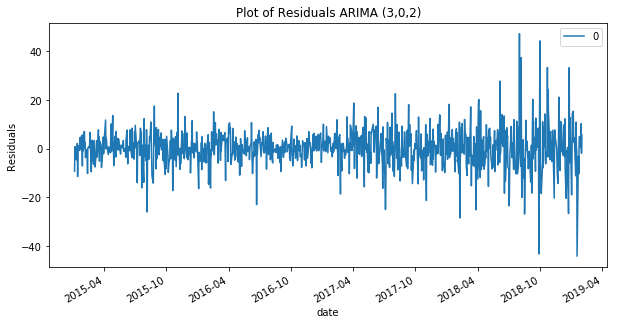

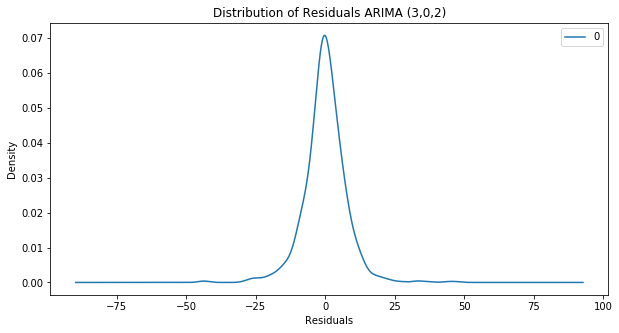

                 0
count  1027.000000
mean      0.000048
std       7.690871
min     -44.100554
25%      -3.672131
50%       0.007584
75%       3.849169
max      47.151003


In [15]:
model = ARIMA(diff, order=(3,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
ax=residuals.plot(title='Plot of Residuals ARIMA (3,0,2)')
ax.set_ylabel("Residuals")
plt.show()
ax2=residuals.plot(kind='kde', title="Distribution of Residuals ARIMA (3,0,2)")
ax2.set_xlabel("Residuals")
plt.show()
print(residuals.describe())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1027
Model:                     ARMA(3, 1)   Log Likelihood               -3560.118
Method:                       css-mle   S.D. of innovations              7.749
Date:                Thu, 07 Mar 2019   AIC                           7132.236
Time:                        20:34:31   BIC                           7161.842
Sample:                             0   HQIC                          7143.474
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1051      0.118      0.894      0.372      -0.125       0.336
ar.L1.close     0.9429      0.038     24.709      0.000       0.868       1.018
ar.L2.close     0.0484      0.043      1.130    

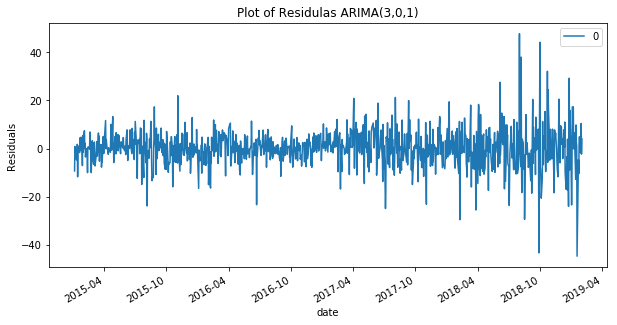

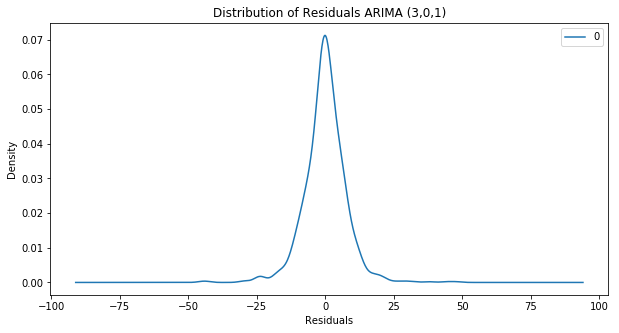

                 0
count  1027.000000
mean     -0.008327
std       7.752564
min     -44.815130
25%      -3.659880
50%       0.060801
75%       3.924275
max      47.819987


In [16]:
model = ARIMA(diff, order=(3,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
ax=residuals.plot(title='Plot of Residulas ARIMA(3,0,1)')
ax.set_ylabel("Residuals")
plt.show()
ax2=residuals.plot(kind='kde',title="Distribution of Residuals ARIMA (3,0,1)")
ax2.set_xlabel("Residuals")
plt.show()
print(residuals.describe())

Another analysis is done to compare the fit of ARIMA(3,0,1) and ARIMA(3,0,2) by comparing the regression model directly with also other fit statistics. As shown in the residual distribution, it is normally distributed with a mean zero indicating both models have good fit and has captured as much information from the series. When looking at the individual AR and MA parameters for statistical significance, we can see that both models proportionally have about the same number of parameters that are significant.  However, the defining difference is the AIC, SBC and HQIC. ARIMA(3,0,2) have much smaller information criterion values compared to ARIMA(3,0,1) indicating less error. Also when looking at the standard deviation of innovations i.e. error term, the ARIMA(3,0,2) has a smaller standard deviation compared to ARIMA(3,0,1). Therefore, with this evidence ARIMA(3,0,2) is the final chosen model.